In [6]:
from dolfin import *
import matplotlib.pyplot as plt
import numpy as np

In [7]:
# Create mesh and define function space
mesh = UnitSquareMesh(16, 16, "left/right")
V = FunctionSpace(mesh, 'Lagrange', 2)

In [10]:
# Define boundary condition
u_D = Expression('1 + x[0]*x[0] + 2*x[1]*x[1]', degree=2)

def boundary(x, on_boundary):
    return on_boundary or near(x[1], 0.5, DOLFIN_EPS)

bc = DirichletBC(V, u_D, boundary)

In [16]:
# Define the coefficient kappa by using expressions
class K(UserExpression):
    
    # Constructor
    def __init__(self, k_0, k_1):
        super().__init__()
        self.k_0 = k_0
        self.k_1 = k_1
    
    def eval(self, value, x):
        # Set value[0] to value at point x
        if x[1] <= 0.5 + DOLFIN_EPS_LARGE:
            value[0] = self.k_0
        else:
            value[0] = self.k_1
            
    def value_shape(self):
        return ()

k_0 = 1
k_1 = 0.5
kappa = K(1, 0.5)

In [18]:
# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Expression('x[1] <= 0.5 + tol ? -6*k_0 : -6*k_1',
               degree=2, tol=1E-14, k_0=k_0, k_1=k_1)
a = kappa*dot(grad(u), grad(v))*dx

# g1 is defined to obtain the analytical solution u_D 
# by using the Neumann condition at the interface y = 0.5
g1 = Expression('x[1] <= 0.5 + tol ? k_0*4*0.5 : k_1*(-4)*0.5',
               degree=2, tol=DOLFIN_EPS_LARGE, k_0=k_0, k_1=k_1)
# The linear form must include the Neunmann boundary condition
L = f*v*dx

In [19]:
# Compute solution
u = Function(V)
solve(a == L, u, bc)

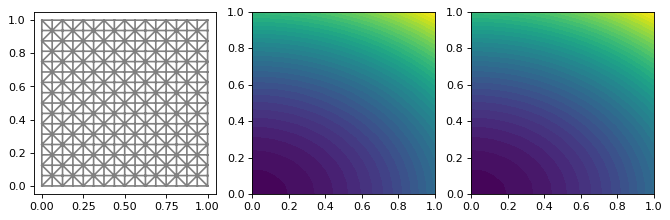

In [20]:
# Plot solution and mesh
plt.figure(figsize=(10, 5), dpi=80)
plt.subplot(1,3,1)
plot(mesh)
plt.subplot(1,3,2)
plot(u)
u_e = Expression('1 + pow(x[0], 2) + 2*pow(x[1], 2)', degree=2)
plt.subplot(1,3,3)
plot(interpolate(u_e, V))
# Save solution to file in VTK format
# vtkfile = File('poisson/solution.pvd')
# vtkfile << u

In [21]:
# Compute error in L2 norm
error_L2 = errornorm(u_e, u, 'L2')

# Compute maximum error at verticies
vertex_values_u_D = u_e.compute_vertex_values(mesh)
vertex_values_u = u.compute_vertex_values(mesh)

error_max = np.max(np.abs(vertex_values_u - vertex_values_u_D))

# Print errors
print('error L2 = ', error_L2)
print('error_max = ', error_max)

error L2 =  0.004195524751623281
error_max =  0.010337009375066097
